In [0]:
!curl https://course.fast.ai/setup/colab | bash

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   321  100   321    0     0   9727      0 --:--:-- --:--:-- --:--:--  9727
Updating fastai...
Done.


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
path = Path(base_dir + 'l3-camvid')
dest = path
dest.mkdir(parents=True, exist_ok=True)

In [0]:
path = untar_data(URLs.CAMVID, dest=dest)

In [0]:
path.ls()

[PosixPath('/content/gdrive/My Drive/fastai-v3/l3-camvid/camvid/labels'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/l3-camvid/camvid/codes.txt'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/l3-camvid/camvid/valid.txt'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/l3-camvid/camvid/images')]

In [0]:
path_lbl = path/'labels'
path_img = path/'images'

In [0]:
#Subset classes
# path = Path('./data/camvid-small')

# def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name

# codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
#     'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

# src = (SegmentationItemList.from_folder(path)
#        .split_by_folder(valid='val')
#        .label_from_func(get_y_fn, classes=codes))

# bs=8
# data = (src.transform(get_transforms(), tfm_y=True)
#         .databunch(bs=bs)
#         .normalize(imagenet_stats))

In [0]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/content/gdrive/My Drive/fastai-v3/l3-camvid/camvid/images/0016E5_01110.png'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/l3-camvid/camvid/images/0016E5_00901.png'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/l3-camvid/camvid/images/0001TP_009900.png')]

In [0]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/content/gdrive/My Drive/fastai-v3/l3-camvid/camvid/labels/0016E5_01080_P.png'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/l3-camvid/camvid/labels/0006R0_f01740_P.png'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/l3-camvid/camvid/labels/0016E5_07140_P.png')]

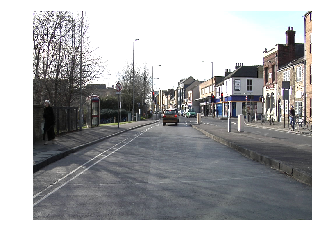

In [0]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [0]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

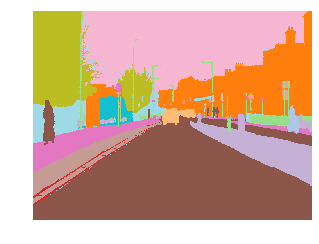

In [0]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [0]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[26, 26, 26,  ...,  4,  4,  4],
          [26, 26, 26,  ...,  4,  4,  4],
          [26, 26, 26,  ...,  4,  4,  4],
          ...,
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17]]]))

In [0]:
codes = np.loadtxt(path/'codes.txt',dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

**Datasets**

In [0]:
import os
from fastai.utils.mem import *

size = src_size//2
free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=8, have 15068MB of GPU RAM free


In [0]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

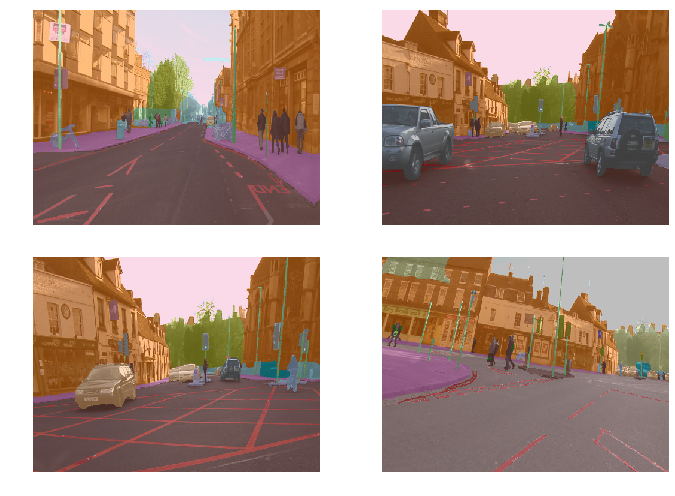

In [0]:
data.show_batch(2, figsize=(10,7))

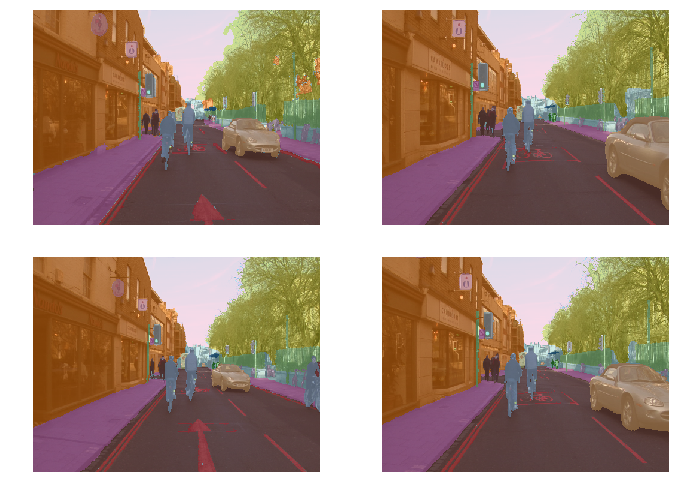

In [0]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

**Model**

In [0]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [0]:
metrics=acc_camvid
# metrics=accuracy

In [0]:
wd=1e-2

In [0]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


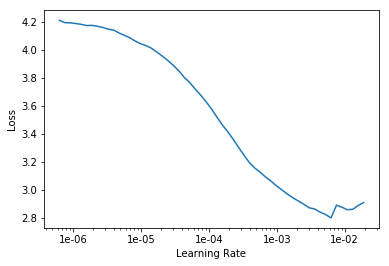

In [0]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr=3e-3

In [0]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.241607,0.795815,0.814237,01:41
1,0.857859,0.665746,0.829174,01:36
2,0.711627,0.632714,0.833166,01:36
3,0.665037,0.630437,0.840430,01:36
4,0.611482,0.527973,0.866430,01:35
5,0.578739,0.616218,0.828476,01:35
6,0.610499,0.430502,0.882876,01:34
7,0.549019,0.438548,0.884237,01:34
8,0.522145,0.420993,0.884600,01:34
9,0.450280,0.346297,0.900175,01:34


In [0]:
learn.save('stage-1')

In [0]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /content/gdrive/My Drive/fastai-v3/l3-camvid/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /content/gdrive/My Drive/fastai-v3/l3-camvid/camvid/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum

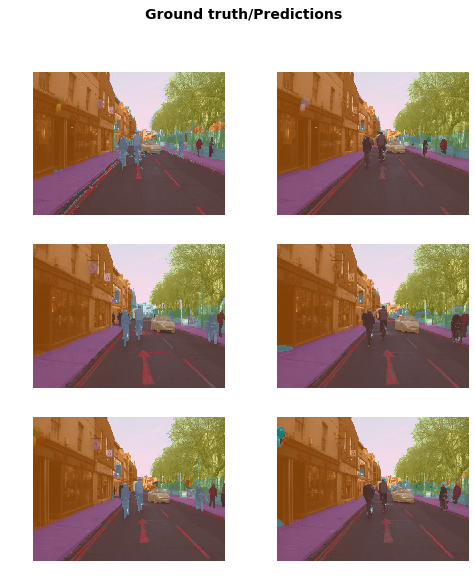

In [0]:
learn.show_results(rows=3, figsize=(8,9))

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(lr/400, lr/4)

In [0]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.385420,0.326254,0.901381,01:35
1,0.375414,0.315701,0.906031,01:37
2,0.365898,0.312351,0.910327,01:38
3,0.351853,0.306973,0.910534,01:39
4,0.342798,0.297888,0.916876,01:38
5,0.334623,0.292833,0.918522,01:38
6,0.328683,0.312225,0.911882,01:37
7,0.321402,0.308641,0.911364,01:38
8,0.311257,0.309413,0.910704,01:38
9,0.306378,0.291772,0.918354,01:38


In [0]:
learn.save('stage-2');

In [0]:
#learn.destroy() # uncomment once 1.0.46 is out

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=2
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=2, have 14309MB of GPU RAM free


In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [0]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:02<00:00, 29495880.77it/s]


In [0]:
learn.load('stage-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


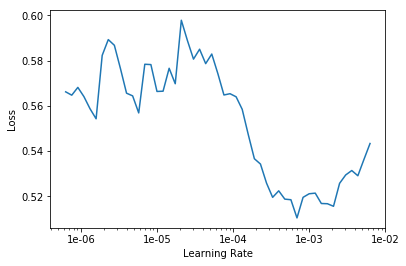

In [0]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr=1e-3

In [0]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.389064,0.320005,0.910448,06:21
1,0.376246,0.329144,0.910819,06:04
2,0.334434,0.301974,0.918816,06:03
3,0.349849,0.312132,0.907443,06:03
4,0.347008,0.301478,0.923554,06:01
5,0.364137,0.308348,0.920308,06:01
6,0.356781,0.280270,0.927079,06:01
7,0.327512,0.296701,0.919173,06:00
8,0.301330,0.253264,0.929352,06:00
9,0.234503,0.242555,0.931128,06:00


In [0]:
learn.save('stage-1-big')

In [0]:
learn.load('stage-1-big');

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(1e-6,lr/10)

In [0]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.228825,0.243538,0.931710,06:16
1,0.221199,0.251316,0.930520,06:14
2,0.227197,0.257436,0.928703,06:14
3,0.209300,0.252702,0.929741,06:14
4,0.210101,0.247306,0.931193,06:14
5,0.208253,0.243763,0.931612,06:15
6,0.197396,0.231068,0.934935,06:14
7,0.193092,0.244130,0.931421,06:15
8,0.191321,0.242437,0.932045,06:15
9,0.190522,0.240197,0.932789,06:15


In [0]:
learn.save('stage-2-big')

In [0]:
learn.load('stage-2-big');

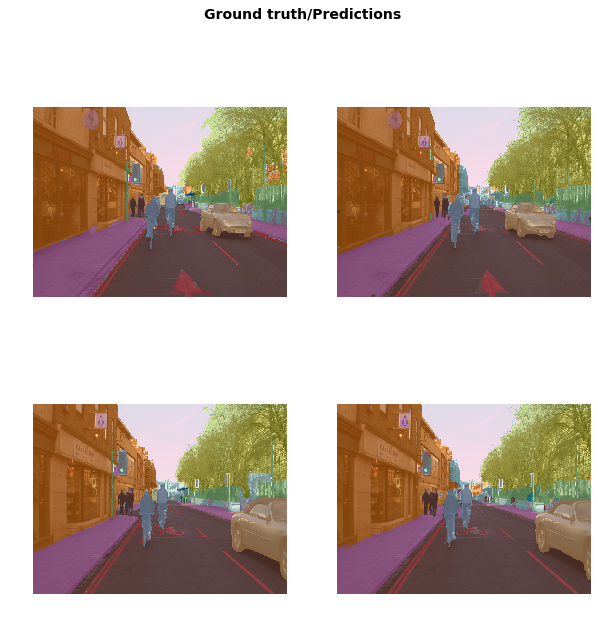

In [0]:
learn.show_results(rows=3, figsize=(10,10))